# SVM RSS Human Rights Classifier

## Gareth Walker

SVM text classifier model trains on state department reports and CIRI data.
Stores most predictive words for CIRI scores.
Predicts 2016,2017,2018 CIRI Scores

#### Outputs

Stores predictions, model performance , and most important features (words) for each CIRI score in pandas DBs: 
Model Predictions of CIRI Scores: 			(‘../data/SVM_Predictions.csv')
Model Features: 						(‘../data/SVM_Features.csv')
Model Train Test Split Performance Data :	 (‘../data/SVM_Performance.csv')


# 1. Model and function definitions 

##  Functions for parsing State Department reports
State deparment reports are seperated by type of human riht violation. However the scrape of reports returns unstructured text. In addition, the titles of the sections vary form year to year. The below script tries to handle this.

In [116]:
import pandas as pd
import sqlite3 as sql
from string import digits
import sys
import numpy as np

def strip_section(infile,titles): # When a title is found, returns all text in that section.
    exit_index = len(infile)
    
    for i in range(len(infile)):
        section_text = infile[i].lower().rstrip().lstrip()
        if section_text in titles:
            exit_index = i
            break
            
    section = ' '.join(infile[0:exit_index])
        
    return section


    
class Parcedatafile:   # Parce through an annual report looking for known section titles.
    def __init__(self,infile):
            
       
        
        arb_kill = ['a. arbitrary peprivation of life and other unlawful or politically motivated killings','a. political and other extrajudicial killing','a. arbitrary deprivation of life and other unlawful or politically motivated killings','a. arbitrary or unlawful deprivation of life',' a. political and other extrajudicial killing']
        disap = ['b. disappearance','b. disappearances']
        tort = ['c. torture and other cruel, inhuman, or degrading treatment or punishment','c. torture and other cruel, inhumane, or degrading treatment or punishment']
        arb_arrest = ['d. arbitrary arrest or detention','d. arbitrary arrest, detention, or exile']
        fair_t = ['e. denial of fair public trial']
        priv = ['f. arbitrary or unlawful interference with privacy, family, home, or correspondence','f. arbitrary interference with privacy, family, home or correspondence','f. arbitrary interference with privacy, family, home, or correspondence']
        conflict = ['g. abuses in internal conflict','g. use of excessive force and violations of humanitarian law in internal conflicts']
        f_exp_press = ['a. freedom of expression, including for the press','a. freedom of speech and press', 'a. freedom of speech and the press']
        f_assembly = ['b. freedoms of peaceful assembly and association','b. freedom of peaceful assembly and association']
        f_religion = ['c. freedom of religion']
        f_move = ['d. freedom of movement','d. freedom of movement within the country, foreign travel, emigration, and repatriation','d. freedom of movement, internally displaced persons, protection of refugees, and stateless persons','d. freedom of movement within the country, foreign']
        f_part_pol  = ['section 3. freedom to participate in the political process','section 3 respect for political rights: the right of citizens to change their government','section 3. respect for political rights: the right of citizens to change their government','section 3 -- respect for political rights: the right of citizens to change their government']
        corrupt  = ['section 4. corruption and lack of transparency in government','section 4. corruption and lack of transparency in government','section 4. official corruption and government transparency']
        gov_att  = ['section 5. governmental attitude regarding international and nongovernmental investigation of alleged abuses of human rights','section 4 governmental attitudes regarding international and nongovernmental investigation of alleged violations of human rights','section 4 -- governmental attitude regarding international and nongovernmental investigation of alleged violations of human rights','section 4 governmental attitude regarding international and nongovernmental investigation of alleged violations of human rights','section 5. governmental attitude regarding international and nongovernmental investigation of alleged violations of human rights','section 5 governmental attitude regarding international and nongovernmental investigation of alleged violations of human rights']
        
        disc_title = ['section 5 discrimination based on race, sex, religion, disability, language, or social status','section 6. discrimination, societal abuses, and trafficking in persons']
        disc_women  = ['women']
        disc_children = ['children']
        disc_disab = ['people with disabilities','persons with disabilities']
        disc_min = ['national/racial/ethnic minorities']
        disc_anti_semit = ['anti-semitism']
        disc_indig =['indigenous people']
        disc_lgbtq = ['acts of violence, discrimination, and other abuses based on sexual orientation and gender identity','societal abuses, discrimination, and acts of violence based on sexual orientation and gender identity']
        disc_hiv =['hiv and aids social stigma','other societal violence or discrimination']
    
        #workers rights
        right_assoc = ['a. freedom of association and the right to collective bargaining','a. the right of association','b. the right to organize and bargain collectively '] #need to find a solution with append to cover multiple matches in single cdocument
        comp_labour = ['b. prohibition of forced or compulsory labor','c. prohibition of forced or compulsory labor']
        child_lab = ['c. prohibition of child labor and minimum age for employment','d. status of child labor practices and minimum age for employment','d. status of child labor practices and minimum age for employment of children','d. prohibition of child labor and minimum age for employment']
        disc_occ = ['d. discrimination with respect to employment and occupation']
        work_cond = ['e. acceptable conditions of work','d. acceptable conditions of work']
        peop_traffic = ['f. trafficking in persons','trafficking in persons']
        
        titles = arb_kill+disap+tort+arb_arrest+fair_t+priv+conflict+f_exp_press+f_assembly+f_religion+f_move+f_part_pol+f_part_pol+corrupt+gov_att+disc_women+disc_children+disc_disab+disc_min+right_assoc+comp_labour+child_lab+disc_occ+work_cond+peop_traffic+disc_anti_semit+disc_indig+disc_lgbtq+disc_hiv+disc_title
        
        
        
         # initialize all of the variables

        self.arbitrary_killings, self.disappearance, self.torture, self.arbitrary_arrest = np.nan, np.nan, np.nan, np.nan
        self.fair_trial, self.privacy, self.abuse_conflict = np.nan, np.nan, np.nan
        self.freedom_exp_press, self.freedom_assembly, self.freedom_religion, self.freedom_movement = np.nan, np.nan, np.nan, np.nan
        self.freedom_participate_political, self.corruption, self.government_attitude, self.discrimination_women = np.nan, np.nan, np.nan, np.nan
        self.discrimination_children, self.discrimination_disabilities, self.discrimination_minorities, self.right_free_association = np.nan, np.nan, np.nan, np.nan
        self.compulsory_labor, self.child_labor, self.discrimination_occupation, self.work_conditions = np.nan, np.nan, np.nan, np.nan
        self.people_trafficking, self.discrimination_anti_semitism, self.discrimination_indigenous, self.discrimination_lgbtq = np.nan, np.nan, np.nan, np.nan
        self.discrimination_hiv = np.nan
        
        for i in range(len(infile)-1):
            
            section_text = infile[i].lower().rstrip().lstrip()
            
            # SECTION 1. RESPECT FOR THE INTEGRITY OF THE PERSON
            if section_text in arb_kill:
                self.arbitrary_killings = strip_section(infile[i+1:],titles)
            if section_text in disap:
                self.disappearance = strip_section(infile[i+1:],titles)
            if section_text in tort:
                self.torture = strip_section(infile[i+1:],titles)
            if section_text in arb_arrest:
                self.arbitrary_arrest = strip_section(infile[i+1:],titles)
            if section_text in fair_t:
                self.fair_trial = strip_section(infile[i+1:],titles)
            if section_text in priv:
                self.privacy = strip_section(infile[i+1:],titles)
            if section_text in conflict:
                self.abuse_conflict = strip_section(infile[i+1:],titles)
            # SECTION 2. RESPECT FOR CIVIL LIBERTIES
            if section_text in f_exp_press:
                self.freedom_exp_press = strip_section(infile[i+1:],titles)
            if section_text in f_assembly:
                self.freedom_assembly = strip_section(infile[i+1:],titles)
            if section_text in f_religion:
                self.freedom_religion = strip_section(infile[i+1:],titles)
            if section_text in f_move:
                self.freedom_movement = strip_section(infile[i+1:],titles)
            # SECTION 3. FREEDOM TO PARTICIPATE IN THE POLITICAL PROCESS
            if section_text in f_part_pol:
                self.freedom_participate_political = strip_section(infile[i+1:],titles)
            # SECTION 4. CORRUPTION AND LACK OF TRANSPARENCY IN GOVERNMENT
            if section_text in corrupt:
                self.corruption = strip_section(infile[i+1:],titles)
            # SECTION 5. GOVERNMENTAL ATTITUDE REGARDING INTERNATIONAL
            #  AND NONGOVERNMENTAL INVESTIGATION OF ALLEGED ABUSES OF HUMAN RIGHTS
            if section_text in gov_att:
                
                self.government_attitude = strip_section(infile[i+1:],titles)
                
                
            # SECTION 6. DISCRIMINATION, SOCIETAL ABUSES, AND TRAFFICKING IN PERSONS
            if section_text in disc_women:
                self.discrimination_women = strip_section(infile[i+1:],titles)
            if section_text in disc_children:
                self.discrimination_children = strip_section(infile[i+1:],titles)                
            if section_text in disc_disab:
                self.discrimination_disabilities = strip_section(infile[i+1:],titles)                
            if section_text in disc_min:
                self.discrimination_minorities = strip_section(infile[i+1:],titles)   
            if section_text in disc_anti_semit:   
                self.discrimination_anti_semitism = strip_section(infile[i+1:],titles)
            if section_text in disc_indig:   
                self.discrimination_indigenous = strip_section(infile[i+1:],titles)
            if section_text in disc_lgbtq:   
                self.discrimination_lgbtq = strip_section(infile[i+1:],titles)           
            if section_text in disc_hiv:   
                self.discrimination_hiv = strip_section(infile[i+1:],titles)
   
                
            # SECTION 7. WORKER RIGHTS
            if section_text in right_assoc:
                self.right_free_association = strip_section(infile[i+1:],titles)
            if section_text in comp_labour:
                self.compulsory_labor = strip_section(infile[i+1:],titles)
            if section_text in child_lab:
                self.child_labor = strip_section(infile[i+1:],titles)
            if section_text in disc_occ:
                self.discrimination_occupation = strip_section(infile[i+1:],titles)
            if section_text in work_cond:
                self.work_conditions = strip_section(infile[i+1:],titles)
            if section_text in peop_traffic:
                self.people_trafficking = strip_section(infile[i+1:],titles)
        
    def todict(self):
        return {
                'Arbitrary Killings' : self.arbitrary_killings,
                'Disappearances': self.disappearance,
                'Torture' : self.torture,
                'Arbitrary Arrest' : self.arbitrary_arrest,
            
                'Free and fair trial' : self.fair_trial,
                'Privacy' : self.privacy,
                'Abuse in conflict' : self.abuse_conflict,
            
                'Freedom of expression' : self.freedom_exp_press, 
                'Freedom of assembly'   : self.freedom_assembly, 
                'Freedom of religion' : self.freedom_religion,
                'Freedom of movement' : self.freedom_movement,
                'Freedom of political participation' : self.freedom_participate_political,
                'Corruption' : self.corruption,
                'Government attitude': self.government_attitude,
            
                'Discrimination against women': self.discrimination_women,
                'Discrimination against children': self.discrimination_children,
                'Discrimination against disabled': self.discrimination_disabilities, 
                'Discrimination against minorities': self.discrimination_minorities,
                'Anti Semitism' : self.discrimination_anti_semitism,
                'Discrimination against indigenous peoples' : self.discrimination_indigenous,
                'Discrimination against HIV / other ' : self.discrimination_hiv,
                'Discrimination against LGBTQ' : self.discrimination_lgbtq,
            
                'Free association' : self.right_free_association,
                'Compulsory or forced labor': self.compulsory_labor,
                'Child_labor': self.child_labor,
                'Discriminaitno by occupation' :self.discrimination_occupation,
                'Working conditions' : self.work_conditions,
                'People trafficking' : self.people_trafficking
                }
    
def parse_row_post_2010(rows): #perform some year specific data cleanin and feed text to parsing alogorythm
    #global master_split
    
    State_reports=pd.DataFrame()
    count = 0
    
    for row in rows:
        
        count += 1
        prog = int((count/len(rows))*100)
        sys.stdout.write("Progress: %d%%   \r" % (prog) )
        sys.stdout.flush()
        
        text = row.replace( 'Share\xa0\xa0\xa0\xa0', '' )
        text = text.replace('\t','')
        master_split = text.split('\n')
        master_split = master_split[85:]   # this is dealing with a feature of scraped pdfs after 2010

        for j in range(len(master_split)-1):
            parced_data = Parcedatafile(master_split)

        State_reports = State_reports.append(parced_data.todict(), ignore_index=True)
        
    return State_reports

def parse_row_pre_2010(rows): #perform some year specific data cleanin and feed text to parsing alogorythm
    #global master_split
    
    State_reports=pd.DataFrame()
    count = 0
    
    for row in rows:
        
        count += 1
        prog = int((count/len(rows))*100)
        sys.stdout.write("Progress: %d%%   \r" % (prog) )
        sys.stdout.flush()
        
        text = row.replace( 'Share\xa0\xa0\xa0\xa0', '' )
        text = text.replace('\t','')
        text = text.replace('\xa0',' ')
        text = text.replace('   ',' ')
        text = text.replace('  ',' ')
        master_split = text.split('\n')
        

        for j in range(len(master_split)-1):
            parced_data = Parcedatafile(master_split)

        State_reports = State_reports.append(parced_data.todict(), ignore_index=True)
        
    return State_reports

def generate_training_data(df):
    

    labels = ['Abuse in conflict', 'Anti Semitism', 'Arbitrary Arrest',
           'Arbitrary Killings', 'Child_labor', 'Compulsory or forced labor',
           'Corruption', 'Disappearances', 'Discriminaitno by occupation',
            'Discrimination against LGBTQ',
           'Discrimination against children', 'Discrimination against disabled',
           'Discrimination against indigenous peoples',
           'Discrimination against minorities', 'Discrimination against women',
           'Free and fair trial', 'Free association', 'Freedom of assembly',
           'Freedom of expression', 'Freedom of movement',
           'Freedom of political participation', 'Freedom of religion',
           'Government attitude', 'Privacy', 'Torture',
           'Working conditions']

    #'Discrimination against HIV / other ', 'People trafficking' removed due to poor performance / low information

    training_data = df[labels].dropna(how='all') # parcing is not perfect: drop reports where algorythm could not recognise sections
    training_data = training_data.unstack().reset_index().drop(columns=['level_1']).dropna() # parcing is not perfect: drop sections where algorythm could not recognise sections
    training_data.columns=['label','text']
    
    return training_data




def split_sentences(label, text):
    split_df = pd.DataFrame()
    split_text = text.split('.')
    split_df['text'] =split_text
    split_df['label']=label
    return split_df



def generate_sentence_training(df):
    rows_done = 0
    total_rows = len(df.index)

    split_training_data = pd.DataFrame(columns = ['label','text'])

    for index, row in df.iterrows():

        rows_done  += 1
        prog = int((rows_done/total_rows)*100)     
        sys.stdout.write("Progress: %d%%   \r" % (prog) )
        sys.stdout.flush() 

        split_training_data = split_training_data.append(split_sentences(row['label'],row['text']))
    
    return split_training_data

##  Functions to consolidate catagories

It was found that model performance on a large number of catagories wasn't great, so the training data can be consolidated into the basic 8 catagories fo transgressions using the following function

In [53]:
integrity_indev = ['Arbitrary Arrest','Disappearances', 
                   'Torture','Arbitrary Arrest','Arbitrary Killings',
                   'Free and fair trial','Privacy',
                   'Abuse in conflict']

civ_lib = ['Freedom of assembly',
           'Freedom of expression',
           'Freedom of movement',
           'Freedom of religion']

political_participation = ['Freedom of political participation']

corruption = ['Corruption']

discrim = [
           'Discrimination against LGBTQ',
           'Discrimination against children',
           'Discrimination against indigenous peoples',
           'Discrimination against minorities',
           'Discrimination against women',
           'People trafficking','Anti Semitism',
            'Discrimination against HIV / other ',
            'Discrimination against disabled',
            'Discriminaitno by occupation']

workers = ['Free association',
           'Child_labor',
           'Compulsory or forced labor',
           'Working conditions']
           
def condense_cat(text):
    
    if text in integrity_indev:
                text = 'Respect for integrity of the person'  
    elif text in civ_lib:
                text = 'Respect for civil liberties' 
    elif text in political_participation:
                text = 'Freedom for political participation'
    elif text in corruption:
                text = 'Corruption and transparency'
    elif text in discrim:
                text = 'Discrimination, societal abuses, human trafficking'
    elif text in workers: 
                text = 'Workers rights'
            
    return(text)

## Define functions for text cleaning

In [54]:
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split

import re


from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.util import ngrams

import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()




#Update stopwords to include corpus specific elements such as countries, nationalities, dates, and standardised terms
countries = pd.read_csv('Data/countries.csv',header=1 )
country_names = countries['Country'].str.lower().tolist()
nationalities = countries['Nationality'].str.lower().tolist()
months = ['january','february','march','april','may', 'june', 'july', 'august', 'september','october','november','december']
days = ['monday','tuesday','wednesday','thursday','friday','saturday','sunday',]
years = np.arange(1900,2030,1)

stopWords.update(country_names)
stopWords.update(nationalities)
stopWords.update(months)
stopWords.update(days)
stopWords.update(years)
additional_stops = ['according','received','anti','general','generally','respect','respected',
                    'provides','practice','including','civil','international','example','small',
                    'gov','www','prohibits','section','constitution','acts',
                    'approximately','number','continued','year','years','percent',
                    'end','new','cases','case','areas','reports','report','reported',
                    'remained','remain','require','required','country','problem','state',
                    'used','human','rights','right','lack','million','high','independent','effectively',
                    'known','widespread','estimated'] 
                    # section specific words in document which cause over-fitting: assessed through inspecting
                    # n highest coefficients of SVM model fitted on un-cleaned text and identifying 
                    # corpus-specific words. Noteworthy that it is mostly the language of official reports
stopWords.update(additional_stops)



def convert(list): 
      
    # Converting integer list to string list 
    s = [str(i) for i in list] 
    
    # Join list items using join()
    s = (" ".join(s)) 
    
    return(s) 


def remove_stops(text): # remove stanard and custom stopwrods
    
    global texts_done
    texts_done  += 1
    prog = int((texts_done/total_text)*100)
               
    sys.stdout.write("Progress: %d%%   \r" % (prog) )
    sys.stdout.flush()
    
    tokenized_words = text.split()
    text = [word for word in tokenized_words if word not in stopWords]
    text = ' '.join(text)
    return(text)

def clean_text(s):
    
    global texts_done
    texts_done  += 1
    prog = int((texts_done/total_text)*100)
               
    sys.stdout.write("Progress: %d%%   \r" % (prog) )
    sys.stdout.flush()
    
    # Convert to lowercase
    s = s.lower()
    
    # remove URLs
    s = re.sub(r"http\S+", "", s)
    
    s = s.replace('\n',' ')

    s = s.replace( "\"", '' )
    
    # Remove aposrphe
    s =s.replace("'", "")
    
    # Replace all none alphanumeric characters with spaces
    s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)

    # Repace all punctuatin with spaces
    s = re.sub(r'[^\w\s]',' ',s)

    #remove digits
    remove_digits = str.maketrans('', '', digits)
    s = s.translate(remove_digits)
    
    # remove isolated numbers (like years)
    #s = re. sub ('\b\d+\b','', s)
    
    # replace all double spaces, tabes, and returns
    s= re.sub(' +', ' ',s)
    
    return(s)


def stem_word(text):
    
    global texts_done
    texts_done  += 1
    prog = int((texts_done/total_text)*100)
               
    sys.stdout.write("Progress: %d%%   \r" % (prog) )
    sys.stdout.flush()
    
    text = text.split(' ')
    stemmed = []
    stemmer = PorterStemmer()
    
    for w in text:
        stemmed.append(stemmer.stem(w))
        
    return (' '.join(stemmed))


def remove_location_ents(text):
    global texts_done
    texts_done  += 1
    prog = int((texts_done/total_text)*100)
               
    sys.stdout.write("Progress: %d%%   \r" % (prog) )
    sys.stdout.flush()
    
    doc= nlp(text)
    drops = ['GPE','NORP','ORG','PERSON']
    GPEs = [x.text for x in doc.ents if x.label_ in drops]
    
    for word in GPEs:
        text = text.replace(word, " ")
    return text





[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/garethwalker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##  Function to re-sample imbalanced classes

In [117]:



def re_sample(df, n):
    dfReSampled = pd.DataFrame()
    labels = df['label'].unique()
    cats = df['label'].unique()
    for label in labels:
        if len(df[df['label']==label])>=n:
            dfReSampled = dfReSampled.append(df[df['label']==label].sample(n=n, random_state=1))
        else:
            dfReSampled = dfReSampled.append(df[df['label']==label].sample(n=n, random_state=2,replace=True))
    return dfReSampled


## Defining model pipelines

In [138]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

import seaborn as sn

sgd = Pipeline([('vect', CountVectorizer()),('model', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=30, tol=None)),])

sgd_ngrams = Pipeline([('vect', CountVectorizer(strip_accents= 'unicode', stop_words='english',ngram_range=(1,2))),
                ('tfidf', TfidfTransformer()),
                ('model', SGDClassifier(class_weight = 'balanced', loss='hinge', penalty='l2', random_state=42, max_iter=30, tol=None)), #alpha=1e-3,
               ])

sgd_ngrams_tfidf = Pipeline([('vect', CountVectorizer(strip_accents= 'unicode', stop_words='english',ngram_range=(1,2))),
                ('tfidf', TfidfTransformer()),
                ('model', SGDClassifier(class_weight = 'balanced', loss='hinge', penalty='l2', random_state=42, max_iter=30, tol=None)), #alpha=1e-3,
               ])

svm = Pipeline([('vect', CountVectorizer(strip_accents= 'unicode', stop_words='english')),
                ('model', LinearSVC(class_weight='balanced')),])


svm_ngrams = Pipeline([('vect', CountVectorizer(strip_accents= 'unicode', stop_words='english',ngram_range=(1,3),max_features=1000)),
                ('model', LinearSVC()),])

svm_ngrams_tfidf = Pipeline([('vect', CountVectorizer(strip_accents= 'unicode',ngram_range=(1,2), stop_words='english',max_features=400)),
                ('tfidf', TfidfTransformer()),
                ('model', LinearSVC()),]) #400 ok

bayes_ngrams_tfidf = Pipeline([('vect', CountVectorizer(strip_accents= 'unicode',ngram_range=(1,2), stop_words='english',max_features=1000)),
                ('tfidf', TfidfTransformer()),
                ('model', MultinomialNB()),])


## Functions to measure model performance

In [198]:


def performance_report(df, CIRI_label):
    df= df[df['Class']==CIRI_label]
    print('accuracy %s' % accuracy_score(df['y_pred'], df['y_test']))
    print(classification_report(df['y_test'],df['y_pred']))
    print(confusion_matrix(df['y_test'],df['y_pred']))
    
def generate_performance_db(df):
    labels = df['Class'].unique()
    df_performance =pd.DataFrame(columns = ['Class','Accuracy','Precision','Recall'])
    
    for i in range(len(labels)):
        label = labels[i]     
        df_of_int= df[df['Class']==label]
        
        df_performance.loc[i,'Class']     =  str(label)
        df_performance.loc[i,'Accuracy']  =  accuracy_score(df_of_int['y_pred'], df_of_int['y_test'])
        df_performance.loc[i,'Precision'] =  precision_score(df_of_int['y_pred'], df_of_int['y_test'],average='micro')
        df_performance.loc[i,'Recall']    =  recall_score(df_of_int['y_test'],df_of_int['y_pred'],average='micro')
        
    return df_performance


def plot_coefficients(pipe,class_number, top_features=20):
    
    feature_names = pipe.named_steps['vect'].get_feature_names()
    coef = pipe.named_steps['model'].coef_[class_number].ravel()  # I think you need to index for each class within the lable
    
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    #print('Top Positive Coefficients: ' + str(top_positive_coefficients))
    
    top_negative_coefficients = np.argsort(coef)[:top_features]
    #print('Top Negative Coefficients: ' + str(top_negative_coefficients))
    
    top_coefficients = np.hstack(top_positive_coefficients)
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]] 
    plt.bar(np.arange(1 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    #print('Feature Names: ' + str(feature_names))
    plt.xticks(np.arange(0, top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    print(feature_names[top_coefficients])

    



def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Functions for driving news parsing and classification

In [148]:
API_KEY = '' # GOOGLE MAPS API KEY REQUIRED 

import requests

def get_location(text):
    
    doc= nlp(text)
    locations = ['GPE'] #,'NORP']
    Locs = [x.text for x in doc.ents if x.label_ in locations]
    
    if not Locs:
        Locs =[' ']
    return Locs[0]

def return_coords(location):
    url = 'https://maps.googleapis.com/maps/api/geocode/json'
    params = {'sensor': 'false', 'address': location,'key': API_KEY}
    r = requests.get(url, params=params)
    results = r.json()['results']
    
    if not results:
        return np.nan, np.nan
    else:   
        location = results[0]['geometry']['location']
    
    return location['lat'], location['lng']

def parce_feeds(feeds,model):
    parced_news=pd.DataFrame()
    additional_data= [bing,UN, guradian_dev,guardain_law,Legal,humanRightsToday]
    other_date_format = [reddit]
    print('Extracting data from feeds')
    for feed in feeds:
        source = feed
        

        parced_feed=pd.DataFrame()
        
        for i in range(len(source['entries'])):
            
            if source in additional_data:
                text = source['entries'][i].title + ' ' + source['entries'][i].description    
            else:
                text = source['entries'][i]['title']
            
            if source in other_date_format:
                parced_feed.loc[i,'Date'] = source['entries'][i].updated
                
            else:
                parced_feed.loc[i,'Date'] = source['entries'][i].published            
                
                
                
            parced_feed.loc[i,'Location'] = get_location(text) 
            text = clean_text(text)
            #text = stem_word(text)
            parced_feed.loc[i,'Text'] = text
            parced_feed.loc[i,'Title'] =  source['entries'][i].title
            parced_feed.loc[i,'Source'] = source['entries'][i].link
            

        #predict catagory
        parced_feed['Label'] = model.predict(parced_feed['Text'])
        
        
        parced_news = parced_news.append(parced_feed)
    
    parced_news = parced_news.replace(r'^\s*$', np.nan, regex=True)
    parced_news = parced_news.dropna() # further data being lost here: where no location was recognised
    parced_news.reset_index(inplace=True)
    parced_news = parced_news.drop(columns='index')
    
    print('Looking up locations')
    for i in range(len(parced_news.index)):
        parced_news.loc[i,'Lat'], parced_news.loc[i,'Long'] = return_coords(parced_news.loc[i,'Location'])
    
    parced_news= parced_news.dropna()
    return parced_news



# 2 . Analysis 

## Read raw scraped data

In [47]:
state_dep = pd.read_csv('Data/us_state_dept_reports_1999_2018.csv')
state_dep.columns = map(lambda x: str(x).upper(), state_dep.columns)   
state_dep.head()


,YEAR,COUNTRY,URL,TEXT,CODE
0,1999,Angola,https://www.state.gov/j/drl/rls/hrrpt/1999/223...,The Republic of Angola's transition from a sin...,24.0
1,1999,Benin,https://www.state.gov/j/drl/rls/hrrpt/1999/227...,The Republic of Benin is a constitutional demo...,204.0
2,1999,Botswana,https://www.state.gov/j/drl/rls/hrrpt/1999/228...,"Botswana is a longstanding, multiparty democra...",72.0
3,1999,Burkina Faso,https://www.state.gov/j/drl/rls/hrrpt/1999/229...,President Blaise Compaore continued to dominat...,854.0
4,1999,Burundi,https://www.state.gov/j/drl/rls/hrrpt/1999/230...,Burundi is ruled by an authoritarian military ...,108.0


This is a one-off run which parses all reports into a csv, in the end it was decided to focus only on recent reports, but the code and data are left here for possible later use

In [16]:
parced_df_1999_2010 = parse_row_pre_2010(state_dep[state_dep['YEAR'].between(1999,2010)].TEXT)
parced_df_2011_2018 = parse_row_post_2010(state_dep[state_dep['YEAR'].between(2011,2018)].TEXT)
all_parced = parced_df_1999_2010.append(parced_df_2011_2018)
all_parced.to_csv('State_Dep_Parced_1999_2018.csv')

## Parse and clean the data

After some trial and error, it turned out that the best approach was to sample each sentence in the section as its own document (as opposed to each section of a report as its own document). This generated a lot more training examples. As such, only data from 2016 to 2018 was used to train the model

In [119]:

print("parsing text")
parsed_data = parse_row_post_2010(state_dep[state_dep['YEAR'].between(2016,2018)].TEXT)

print('formating for training')
training_data = generate_training_data(parsed_data)

print('spliting text')
split_training_data = generate_sentence_training(training_data)


mask = (split_training_data['text'].str.len() > 30)

split_training_data_filt = split_training_data[mask]
split_training_data_filt.groupby('label').count()
split_training_data_filt.to_csv('split_training_data.csv')

clean_data = split_training_data_filt.copy(deep=True)

total_text = len(clean_data.index)
texts_done=0
print('Cleaning text')
clean_data.text = clean_data.text.apply(lambda x: clean_text(x))

texts_done=0
print('Removing stop words')
clean_data.text = clean_data.text.apply(lambda x: remove_stops(x))
clean_data.to_csv('cleaned_data_not_stemmed_no_NLP.csv')


parsing text
formating for training
spliting text


/Users/garethwalker/anaconda3/envs/DataChallenge/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Cleaning text%   


### Optional cleaning stages

I experimented with removing named entities in the training data to reduce the bias of the model. It's a very time consuming proccess with limited impact, so I leave it as an optional step

In [ ]:
# Remove entities : Note: This needs to be carried out before basic cleaning as entity detection uses punctuation
texts_done=0
total_text = len(clean_data.index)
print('Removing entitites')
clean_data.text = clean_data.text.apply(lambda x: remove_location_ents(x))

In [2005]:
texts_done=0
print('Stemming Text')
clean_data.text = clean_data.text.apply(lambda x: stem_word(x))
clean_data.to_csv('cleaned_data_stemmed.csv')

Stemming Text


## Consolidate catagories
It was found that the model did not perform well with the full complement of catagories in the data. Mostly due to the fact that news headlines are often not that specific. The broader basic catagories (of which there are 6, listed below), were eventually selected as the best performing granularity. This code consolidates the  catagories.

In [120]:
clean_data_cons = clean_data.copy(deep=True)

In [121]:
clean_data_cons = clean_data_cons[clean_data_cons['label']!='Government attitude']
clean_data_cons = clean_data_cons[clean_data_cons['label']!='Discrimination against disabled']
clean_data_cons = clean_data_cons[clean_data_cons['label']!='Discriminaitno by occupation']


In [122]:
clean_data_cons.label = clean_data_cons.label.apply(lambda x: condense_cat(x))

## Adress imbalanced classes
A basic bootstrap method is used.

In [123]:
clean_data_cons.groupby('label').count()

,text
label,
Corruption and transparency,10665
"Discrimination, societal abuses, human trafficking",53376
Freedom for political participation,11462
Respect for civil liberties,51003
Respect for integrity of the person,80501
Workers rights,48222


In [124]:
clean_data_cons_balanced = re_sample(clean_data_cons,20000)
clean_data_cons_balanced.groupby('label').count()

,text
label,
Corruption and transparency,20000
"Discrimination, societal abuses, human trafficking",20000
Freedom for political participation,20000
Respect for civil liberties,20000
Respect for integrity of the person,20000
Workers rights,20000


## Train broad catagory model

In [174]:
X = clean_data_cons_balanced.text
y = clean_data_cons_balanced.label
broad_model = svm_ngrams_tfidf
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state = 42)

print('Fitting to training data')
broad_model.fit(X_train, y_train)
print('Predicting test data')
y_pred = broad_model.predict(X_test)


Fitting to training data
Predicting test data


   Accuracy: 0.762
                                                    precision    recall  f1-score   support

                       Corruption and transparency       0.77      0.74      0.76      1008
Discrimination, societal abuses, human trafficking       0.69      0.75      0.72      1004
               Freedom for political participation       0.85      0.84      0.84       971
                       Respect for civil liberties       0.73      0.68      0.70       948
               Respect for integrity of the person       0.68      0.71      0.70      1033
                                    Workers rights       0.86      0.86      0.86      1036

                                         micro avg       0.76      0.76      0.76      6000
                                         macro avg       0.76      0.76      0.76      6000
                                      weighted avg       0.76      0.76      0.76      6000



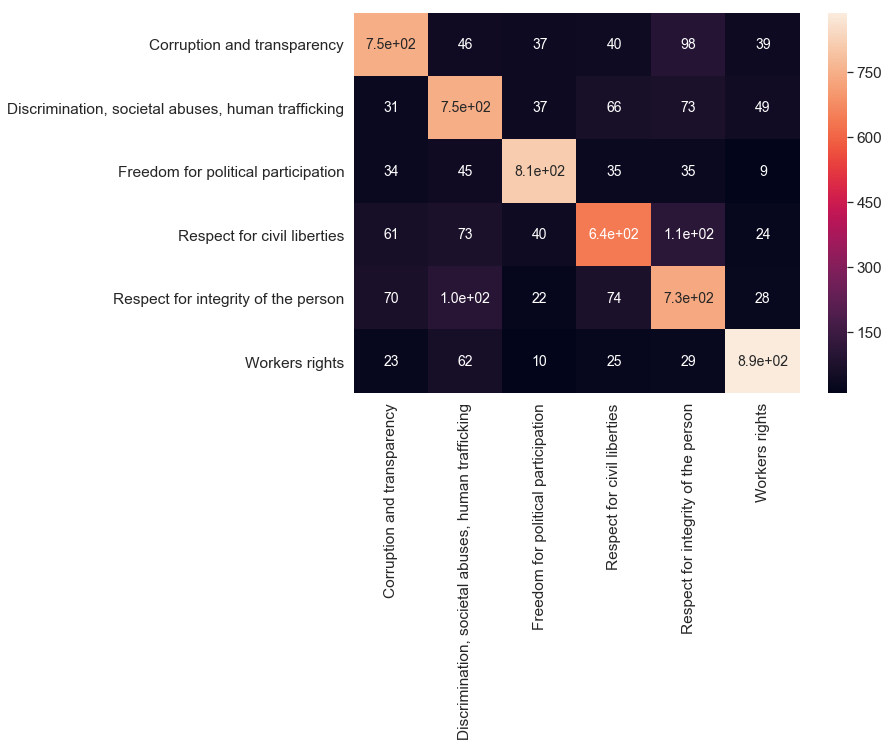

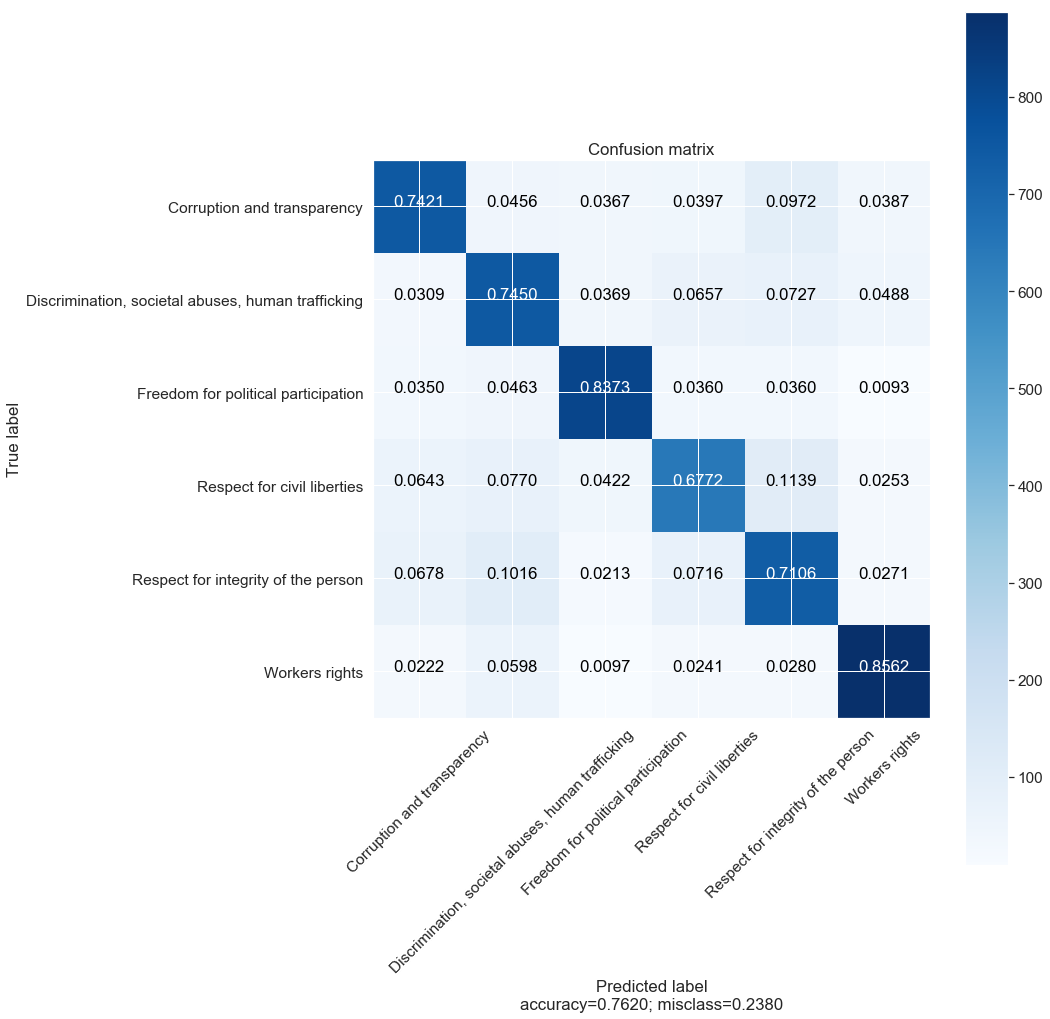

In [199]:
#Report model performance
print('   Accuracy: %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred),index=list(broad_model.classes_), columns=list(broad_model.classes_))
sn.set(font_scale=1.4)#for label size
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,annot_kws={"size": 14})# font size


plot_confusion_matrix(confusion_matrix(y_test,y_pred),list(broad_model.classes_))

In [176]:
print('Fitting to all data')
broad_model.fit(X, y)
print('Saving model')
import pickle
pkl_filename = "SVM_Human_Rights_Broad_Model.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(svm_ngrams_tfidf, file)

Fitting to all data
Saving model


## Parse news feeds

In [81]:

import feedparser
UN = feedparser.parse('https://news.un.org/feed/subscribe/en/news/topic/human-rights/feed/rss.xml')
HRW = feedparser.parse('https://www.hrw.org/rss/news')
Legal = feedparser.parse('https://www.loc.gov/law/foreign-news/topic/human-rights-and-civil-liberties/feed/')
reddit = feedparser.parse('https://www.reddit.com/r/humanrights/.rss?format=xml')
guradian_dev =feedparser.parse('https://www.theguardian.com/global-development/human-rights/rss')
guardain_law = feedparser.parse('https://www.theguardian.com/law/human-rights/rss')
global_gov = feedparser.parse('https://www.globalgovernancewatch.org/rss/cf/business-and-human-rights')
bing = feedparser.parse('https://www.bing.com/news/search?q=human+rights&qft=interval%3d%229%22&form=PTFTNR&format=rss')
google = feedparser.parse('https://www.google.com/alerts/feeds/15148002122748980858/15524676848914345641')
humanRightsToday = feedparser.parse('https://humanrights.einnews.com/rss/FArWteAQFHbsjpvX')

feeds = [HRW,Legal,guradian_dev,guardain_law,global_gov,bing,google,reddit,humanRightsToday] # UN removed: stories tend to summarise more than one event

## Catagorise and locate news items

In [177]:
parced_news_feeds = parce_feeds(feeds,broad_model)

Extracting data from feeds
Looking up locations


In [180]:
parced_news_feeds.to_csv('parced_news_may_19.csv') # save the outputs


## Evaluate model outputs

In [178]:
parced_news_feeds.groupby(['Label']).count()

,Date,Location,Text,Title,Source,Lat,Long
Label,,,,,,,
Corruption and transparency,11,11,11,11,11,11,11
"Discrimination, societal abuses, human trafficking",36,36,36,36,36,36,36
Freedom for political participation,8,8,8,8,8,8,8
Respect for civil liberties,15,15,15,15,15,15,15
Respect for integrity of the person,27,27,27,27,27,27,27
Workers rights,9,9,9,9,9,9,9


In [190]:
parced_news_feeds[['Label','Title']].head()

,Label,Title
0,Respect for integrity of the person,Thailand: No Justice 9 Years After ‘Red Shirt’...
1,Respect for integrity of the person,Sri Lanka: Failed Pledges Mar 10 Years Since W...
2,"Discrimination, societal abuses, human traffic...",#LoveWins in Taiwan
3,"Discrimination, societal abuses, human traffic...",Don’t Be Fooled by Azerbaijan at Europa League...
4,Freedom for political participation,Philippines ‘Drug War’ Top Cop Elected to Senate


In [151]:
parced_news_feeds[parced_news_feeds['Label']=='Discrimination, societal abuses, human trafficking'].Title.values

array(['#LoveWins in Taiwan',
       'Don’t Be Fooled by Azerbaijan at Europa League Football Final',
       'Italy: Reject Anti-Rescue Proposals',
       'Israel’s Eurovision: ‘Dare to Dream’ Unless You’re Caged in Gaza',
       'Alabama’s Abortion Ban Is A Dark Day for Women',
       'Prosecute DR Congo’s General Amisi',
       'Bahrain: Suspend Death Penalty',
       'Germany: De Facto Complete Exclusion of Stepchild Adoption for Unmarried Couples Held Unconstitutional',
       "'Moral panic' over gender identity film sparks backlash in Indonesia",
       "China 'failing trans people' as young attempt surgery on themselves –\xa0study",
       'Speech that led to death threats against an Armenian trans activist – video',
       'Armenian MPs call for trans activist to be burned alive after historic speech',
       'Paul Kagame orders release of women and girls jailed over abortion in Rwanda',
       'UK charity knew of alleged abuse in Congo parks but did not act',
       '‘There are

In [152]:
parced_news_feeds[parced_news_feeds['Label']=='Corruption and transparency'].Title.values

array(['Brazil: Brazilian President Signs Acts Addressing Bureaucracy, Corruption, and Drug Policy',
       'Russia: Russian President Signs Anti-fake News Laws',
       'Brazil: Federal Supreme Court Orders Criminal Investigation into Fake News Involving the Court',
       'British watchdog launches inquiry into WWF abuse allegations',
       'Global war on drugs could harm efforts to abolish death sentences - study',
       'Dutchess County <b>Human Rights</b> Commission plans June 5 &#39;listening session&#39; in Stanfordville',
       'Gaza blockade causes ‘near ten-fold increase’ in food dependency, says UN agency',
       'Iran: US Acts against UN Charter, Human Rights',
       "Ministers agree on Russia return to rejoin Europe's human rights body",
       "Ministers agree way for Russia to rejoin Europe's human rights body",
       'Jailed Ugandan Activist Stella Nyanzi Wins Human Rights Award'],
      dtype=object)

In [153]:
parced_news_feeds[parced_news_feeds['Label']=='Workers rights'].Text.values

array(['morocco law misused to silence reporters',
       'iran labor activists detained since may day',
       'ukraine legislature adopts language law may on april the verkhovna rada ukraine s legislature adopted a law enhancing the role of ukrainian as a state language proekt zakonu pro zabespechennya funktsionuvannya ukrainskoi movi yak derzhavnoi law on ensuring the functioning of the ukrainian language as a state language verkhovna rada website scroll down and click tekst zakonoproektu ',
       'europe accused of financing eritrean project based on forced labour p campaigners say m eu scheme uses recruits from eritrea s national service a system likened to mass enslavement p p eritreans in exile have launched legal proceedings against the eu accusing it of financing a scheme in eritrea that uses forced labour p p the netherlands based a href human rights for eritreans a fhre has a href on the eu to immediately stop a m m road construction project which it says violates human rig

In [154]:
parced_news_feeds[parced_news_feeds['Label']=='Respect for civil liberties'].Title.values

array(['France: Guarantee Press Freedom',
       'Syria: Women’s Rights in Light of New Amendments to Syrian Personal Status Law',
       "UK policy on migration 'disconnected and incoherent', MPs warn",
       "Study warns of global rise in autocratic leaders 'hijacking' laws for own ends",
       'Millions of Ugandans quit internet services as social media tax takes effect',
       'In Northern Ireland, our hearts break for Alabama: we know about abortion bans | Elizabeth Nelson',
       'Belgian antisemitism and anti-kosher laws | Letters',
       'Asylum seekers in Ireland are intimidated into silence over their poor treatment | Emer O’Toole',
       'Human Rights Watch Report Details New Crackdown On Journalists In Morocco',
       "UN tells Italy proposed decree violates migrants' rights",
       'UN tells Italy proposed decree violates migrants&#39; <b>rights</b>',
       'UN tells Italy proposed decree violates migrants&#39; <b>rights</b>',
       "Protection of human rights to

In [158]:
parced_news_feeds[parced_news_feeds['Label']=='Respect for integrity of the person'].Title.values

array(['Thailand: No Justice 9 Years After ‘Red Shirt’ Crackdown',
       'Sri Lanka: Failed Pledges Mar 10 Years Since War’s End',
       'Brazil Court Delay Leaves Zika Families in Limbo',
       'Italy: Legal Provision Not Allowing Home Detention Ruled Unconstitutional',
       'Finland: Parliament Revokes Law Exempting Jehovah’s Witnesses from Mandatory Military Service',
       'UAE: Court Orders Doctors to Pay Blood Money to Patient’s Family',
       'UN urges worldwide withdrawal of support for Myanmar military',
       "'We will lose any hope of going home': Rohingya live in fear of resettlement",
       'The Guardian view on Xinjiang’s detention camps: not just China’s shame | Editorial',
       'Egypt executed 15 people in February. Why is the UK staying silent? | Rhys Davies',
       'The Guardian view on prosecuting war crimes: no one is above the law | Editorial',
       'UK government security decisions can be challenged in court, judges rule',
       'Adani deal with Mya

In [157]:
parced_news_feeds[parced_news_feeds['Label']=='Freedom for political participation'].Text.values

array(['philippines drug war top cop elected to senate',
       'japan law requiring surgery for legal change of gender ruled constitutional apr on january japan s supreme court held that a law requiring that transgender people undergo gender change surgery in order to have their gender changed on official documents is constitutional supreme court ku no jan click on the two characters beside the pdf icon supreme court of japan website ',
       'council of europe votes to maintain russias membership p human rights body had stripped moscow of its voting rights over crimea annexation p p russia will remain in the council of europe after ministers at the human rights organisation moved to end a bitter dispute following the a href of crimea a p p meeting in helsinki ministers of the nation body voted overwhelmingly in favour of a declaration that said all member states should be entitled to participate on an equal basis in the council s committee of ministers and parliamentary assembly p a

## Exploring model performance and architecture

In [182]:
perform_df = pd.read_csv('Data/parced_news_may_9-6_evaluation.csv')
perform_df.dropna()
perform_df['Unnamed: 6'] = perform_df['Unnamed: 6'].astype(str)
perform_df['Label'] = perform_df['Label'].astype(str)

In [183]:
y_test = perform_df['Unnamed: 6']
y_pred = perform_df['Label']

In [184]:
sorted(list(y_test.unique()))

['Corruption and transparency',
 'Discrimination, societal abuses, human trafficking',
 'Freedom for political participation',
 'Respect for civil liberties',
 'Respect for integrity of the person',
 'Workers rights']

   Accuracy: 0.6732673267326733
                                                    precision    recall  f1-score   support

                       Corruption and transparency       1.00      0.50      0.67         4
Discrimination, societal abuses, human trafficking       0.83      0.56      0.67        27
               Freedom for political participation       0.00      0.00      0.00         4
                       Respect for civil liberties       0.57      0.67      0.62        30
               Respect for integrity of the person       0.67      0.85      0.75        34
                                    Workers rights       0.67      1.00      0.80         2

                                         micro avg       0.67      0.67      0.67       101
                                         macro avg       0.62      0.60      0.58       101
                                      weighted avg       0.67      0.67      0.66       101



/Users/garethwalker/anaconda3/envs/DataChallenge/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/garethwalker/anaconda3/envs/DataChallenge/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/garethwalker/anaconda3/envs/DataChallenge/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


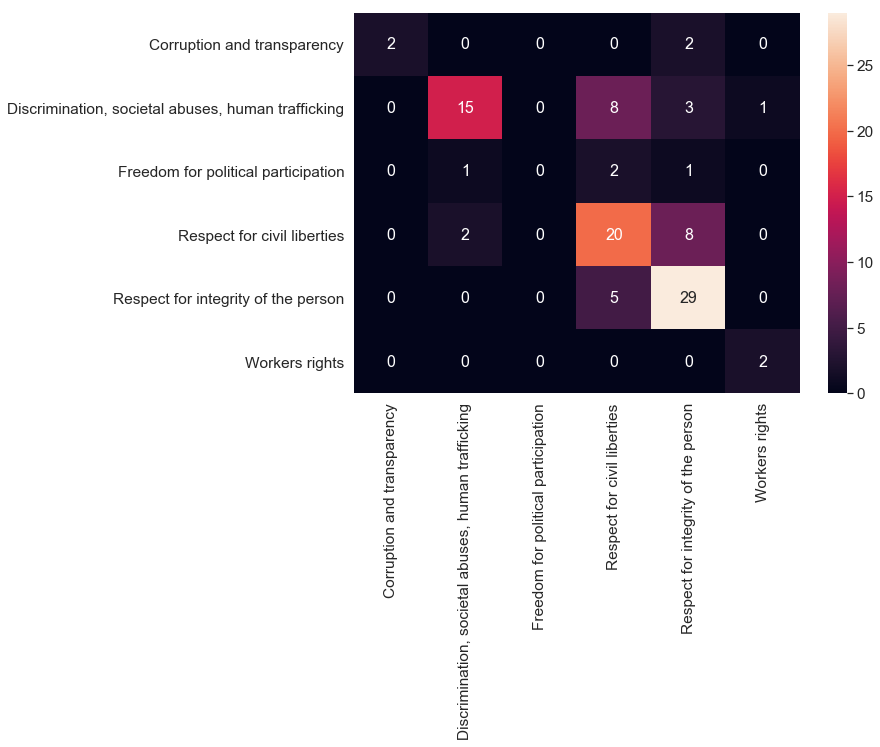

In [185]:
print('   Accuracy: %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred),index=sorted(list(y_test.unique())), columns=sorted(list(y_test.unique())))
sn.set(font_scale=1.4)#for label size
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

In [2030]:
broad_model.classes_

array(['Corruption and transparency',
       'Discrimination, societal abuses, human trafficking',
       'Freedom for political participation',
       'Respect for civil liberties',
       'Respect for integrity of the person', 'Workers rights'],
      dtype=object)

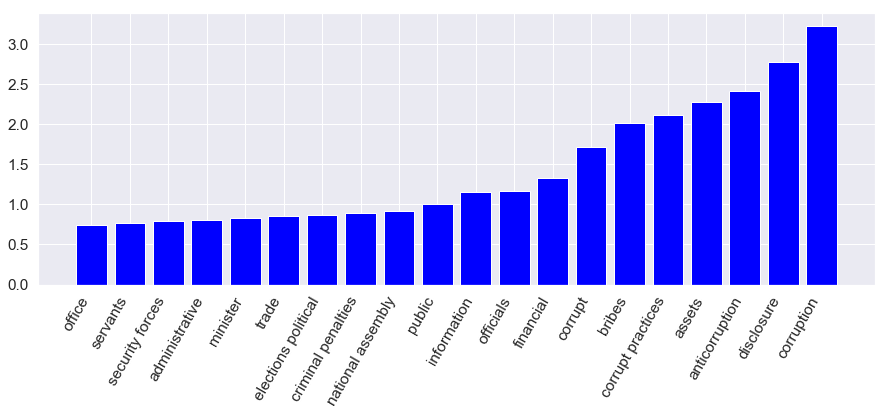

['office' 'servants' 'security forces' 'administrative' 'minister' 'trade'
 'elections political' 'criminal penalties' 'national assembly' 'public'
 'information' 'officials' 'financial' 'corrupt' 'bribes'
 'corrupt practices' 'assets' 'anticorruption' 'disclosure' 'corruption']


In [189]:
plot_coefficients(broad_model,0)

# Check for overfitting

In [170]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



Automatically created module for IPython interactive environment


/Users/garethwalker/anaconda3/envs/DataChallenge/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


<module 'matplotlib.pyplot' from '/Users/garethwalker/anaconda3/envs/DataChallenge/lib/python3.7/site-packages/matplotlib/pyplot.py'>

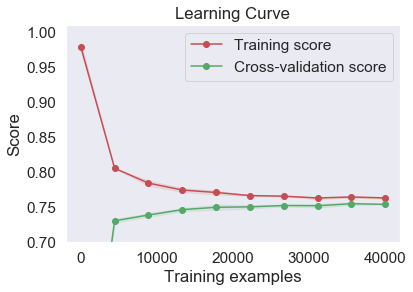

In [173]:
randomiser = np.random.randint(len(X), size=len(X))

X = clean_data_cons_balanced.text.values[randomiser]
y = clean_data_cons_balanced.label.values[randomiser]
estimator = svm_ngrams_tfidf

plot_learning_curve(estimator, 'Learning Curve', X, y, ylim=(0.7, 1.01), n_jobs=-1,train_sizes=np.linspace(.001, .50, 10))